<a href="https://colab.research.google.com/github/tedteske/bounded_lognorm/blob/master/bounded_lognorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

The **bounded lognormal** is a continuous probability distribution derived from the [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution). Unlike the normal and lognormal distributions, the  domain of the bounded lognormal has both upper and lower bounds, and it may be symmetrical or skewed, depending on the parameters. It therefore may be a good fit for many natural phenomena, for which there are known limits, for example adult male height. 

The lognormal probability density function (pdf) is often defined in terms of $\mu_N$ and $\sigma_N$, the mean and standard deviation of some normal distribution $N$:


$$
f_L(x, \mu_N, \sigma_N ) = \frac{1}{x \sigma_N \sqrt{2 \pi}} \times exp(\frac{-(\ln(x) - \mu_N)^2}{2\sigma_N^2}) \tag{1}
$$

If we redefine $f_L$ in terms of mode $m$ and standard deviation $\sigma$ as $f_{L'}$, then the bounded lognormal pdf $f_{BL}$ is the piecewise function:

$$
f_{BL}(x, m, \sigma, upper) =
  \begin{cases}
    f_{L'}(x, m, \sigma)   &  \text{for } x <= m \\
    f_{L'}(upper-x, upper-m, \sigma)   &  \text{for } x > m \\
  \end{cases} \tag{2}
$$

where the second piece is scaled so that $f_{BL}$ is continuous at the mode, and $(lower, upper)$ are the lower and upper bounds of the domain.

### Python Implementation: Class Definition

The bounded lognormal distribution is implemented in Python as an instance of the [scipy.stats.rv_continuous](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous) class and inherits from it a collection of generic methods.

In [2]:
#
# Author: Ted Teske 2020 
#          

from scipy.stats import rv_continuous, norm
from scipy.integrate import quad, cumtrapz, trapz
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np

"""
The following optional imports and plotting settings are for the examples
below, but not necessary for the class definition itself.
"""
from scipy.stats import truncnorm, kurtosis, normaltest
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [10, 10/1.6]
"""
End of optional section.
"""


def lognorm_pdf(x, mu_N, sigma_N):
    """
    Log-normal (aka lognormal) probability density function.

    Parameters
    ----------
    x : {float, list or ndarray of floats}
        x-value(s)
    mu_N : float
        mean of underlying normal distribution
    sigma_N : float
        standard deviation of underlying normal distribution

    Returns
    -------
    y : ndarray of float(s)

    References
    ----------
    [1] https://en.wikipedia.org/wiki/Log-normal_distribution
    """

    # Creates an index of positive elements in x.
    i = np.nonzero(x > 0)

    # Applies lonormal pdf to positive elements.
    # All others evaluate to 0.
    y = np.zeros(len(x))
    y[i] = 1 / (x[i] * sigma_N * np.sqrt(2 * np.pi)) \
        * np.exp(-(np.log(x[i]) - mu_N)**2 / (2 * sigma_N**2))
    return y


def lognorm_params(mode, sigma):
    """
    Given user-defined mode and sigma of a lognormal distribution,
    calculates the mu and sigma of its underlying normal distribution.

    Parameters
    ----------
    mode : float
        mode of lognormal distribution
    sigma : float
        standard deviation of lognormal distribution

    Returns
    -------
    mu_N : float
    sigma_N : float

    References
    ----------
    [1] Adapted from Warren Weckesser's ansnwer to question at
        https://stackoverflow.com/questions/41464753
    """

    # find the roots of the polynomial
    # g^4 - g^3 - sigma^2/mode^2
    # where g = e^(variance of the associated Normal distribution)
    p = np.poly1d([1, -1, 0, 0, -(sigma/mode)**2])
    r = p.roots

    # just the real, positive root
    solution = r[(r.imag == 0) & (r.real > 0)].real

    sigma_N = np.sqrt(np.log(solution))
    mu_N = np.log(mode * solution)
    return mu_N, sigma_N


class bounded_lognorm_gen(rv_continuous):
    """
    Subclass of scipy.stats.rv_continuous [1]. This is used to generate a
    bounded lognormal continuous probability distribution, which is fully 
    described by the four parameters mode, sigma, lower and upper bounds.

    The probability density function (pdf) concatenates two lognormal pdf
        1. left-of-mode: lognormal pdf with loc at lower bound, and 
        2. right-of-mode: reversed lognormal pdf with loc at upper bound and 
            scaled so that the concatenated pdf is continuous at the mode.
    and scales the concatenated curve so that its integral equals 1.

    Methods
    -------
    same as scipy.stats.rv_continuous [1]

    References
    ----------
    [1] https://docs.scipy.org/doc/scipy/reference/generated
        /scipy.stats.rv_continuous.html
    """

    def _pdf(self, x, mode, sigma, lower, upper):
        """
        Probability density function (pdf)

        Parameters
        ----------
        x : {float, list, ndarray of floats}
            x-value(s)
        mode : float
            x at the point of maximum frequency [1]
        sigma : float
            indicates spread of data around mode. This approaches the standard 
            deviation as lower and upper are increasingly distant from x.
        lower : float
            lower bound of the domain (x-values)
        upper : float
            upper bound of the domain (x-values)

        Returns
        -------
        relative likelihood [2] of x : ndarray of float(s)

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Mode_(statistics)
        [2] https://en.wikipedia.org/wiki/Probability_density_function
        """

        # shifts x, lower, upper, and mode so that lower is at 0;
        # allows negative x-values 
        x, mode, upper = x - lower, mode - lower, upper - lower
        
        # concatenates left- and right-of-mode pdfs
        y = self.concat_pdf(x, mode, sigma, upper)
        
        # normalizes concatenated pdf to area = 1
        if hasattr(x, "__len__") and len(x) >= 1000:
            scale = trapz(y, x)
        else:    
            scale, _ = quad(lambda j: self.concat_pdf(j, mode, sigma, upper), 
                            0, upper)
        return y / scale
    
    def _cdf(self, x, mode, sigma, lower, upper):
        """
        Cumulative density function (cdf). See _pdf() for list of parameters.
        """
        x_, y_ = self.discrete_cdf(x, mode, sigma, lower, upper)
        return interp1d(x_, y_, axis=0, fill_value="extrapolate")(x)

    def _ppf(self, p, mode, sigma, lower, upper):
        """
        Percent point function (ppf), inverse of cdf. See _pdf() for list 
        of parameters.
        """
        x_, y_ = self.discrete_cdf(p, mode, sigma, lower, upper)
        return interp1d(y_, x_, axis=0, bounds_error=False,
                        fill_value=(lower, upper))(p) 
 
    def _logpdf(self, x, mode, sigma, lower, upper):
        """
        Natural log of the pdf. See _pdf() for list of parameters.
        """
        return np.log(self.pdf(x, mode, sigma, lower, upper))
    
    def _argcheck(self, *args):
        """
        Overrides default _argcheck to allow negative parameters. Returns 
        condition array of 1s where arguments are correct and 0s where they 
        are not.
        """
        for arg in args:
            cond = np.isfinite(arg)
        return cond
    
    def pdf(self, x, mode, sigma, lower, upper):
        """
        Wrapper for _pdf that converts parameters to scalars, if necessary
        """
        try:
            mode, sigma, lower, upper = mode[0], sigma[0], lower[0], upper[0]
        except:
            pass  
        return self._pdf(x, mode, sigma, lower, upper)
    
    def cdf(self, x, mode, sigma, lower, upper):
        """
        Wrapper for _cdf
        """
        return self._cdf(x, mode, sigma, lower, upper)
   
    def ppf(self, p, mode, sigma, lower, upper):       
        """
        Wrapper for _ppf that provides a value for p == 1
        """
        y = np.where(p == 1.0, 
                     upper,
                     self._ppf(p, mode, sigma, lower, upper))
        """
        # This is an alternate way, but appears to be slightly slower.
        
        # converts to numpy array if p is a scalar or list
        if not isinstance(p, (pd.core.series.Series, np.ndarray)):
            p = np.array([p])
        
        y = np.zeros(len(p))
        y[p < 1] = self._ppf(p[p < 1], mode, sigma, lower, upper)
        y[p >= 1] = upper
        """
        return y
    
    def concat_pdf(self, x, mode, sigma, upper):
        """
        Concatenates left- and right-of-mode pdfs
        """
        # converts to numpy array if x is a scalar or list
        if not isinstance(x, (pd.core.series.Series, np.ndarray)):
            x = np.array([x])

        # left side
        mu_N_left, sigma_N_left = lognorm_params(mode, sigma)
        x_left = np.append(x[x <= mode], [mode], axis=0)
        y_left = lognorm_pdf(x_left, mu_N_left, sigma_N_left)

        # right side
        mu_N_right, sigma_N_right = lognorm_params((upper - mode), sigma)
        x_right = np.append(x[x > mode], [mode], axis=0)
        y_right = lognorm_pdf(upper - x_right, mu_N_right, sigma_N_right)
        
        # scale right side so that left and right sides continuous at mode
        y_right = y_right * (y_left[-1] / y_right[-1]) 
        y = np.append(y_left[:-1], y_right[:-1], axis=0)
        return y
    
    def discrete_cdf(self, x, mode, sigma, lower, upper, min_samples=10000):
        """
        Discrete cdf. Called by cdf(), which uses interpolation to convert 
        output of discrete_cdf() to a continuous cdf.
        """
        if hasattr(x, "__len__") and len(x) > min_samples:
            min_samples = len(x)
        x_ = np.linspace(lower, upper, min_samples, endpoint=True) 
        x_ = x_.squeeze()
        y = self._pdf(x_, mode, sigma, lower, upper)
        y_ = cumtrapz(y, x_, initial=0)
        return x_, y_

    def fit(self, data, xdata=None, MLE=False,
            fmode=None, fsigma=None, flower=None, fupper=None,
            gmode=None, gsigma=None, glower=None, gupper=None):
        '''
        Fits random variates (if xdata is None) or histogram to a pdf by 
        estimating bounded_lognorm parameters.

        Parameters
        ----------
        data : {list of floats, ndarray of floats}
            random variates or relative likelihoods (if xdata is not None)
        xdata : {None, list of floats, ndarray of floats}, of length len(data)
            histogram bins
        MLE : boolean 
            If True, use maximum likelihood estimation.
            If False, use least squares estimation (default).
        fmode, fsigma, flower, fupper : {None, float} 
            parameters held to fixed constants
        gmode, gsigma, glower, gupper : {None, float} 
            initial guesses, overridden by fixed parameters

        Returns
        -------
        shapes : ndarray 
            shape parameters (mode, sigma, lower, upper)
        popt : ndarray
            estimated (i.e. non-fixed) parameters
        pcov : {ndarray, None}
            estimated covariance matrix of popt or None if MLE=True 

        Note
        ----
        "The diagonals [of pcov] provide the variance of the parameter 
        estimate. To compute one standard deviation errors on the parameters 
        use perr = np.sqrt(np.diag(pcov))." [1]

        References
        ----------
        [1] https://docs.scipy.org/doc/scipy/reference/generated
            /scipy.optimize.curve_fit.html
        '''
              
        # If xdata is not None, then assume data are relative frequencies and
        # xdata are bins. If xdata is None, assume data are random variates 
        # and convert to a histogram.
        if xdata is None:
            sample_size = len(data)
            data, xdata = np.histogram(data, density=True, bins=sample_size)
            xdata = np.mean([xdata[:-1], xdata[1:]], axis=0)
        
        # Colllect fixed parameters in fparams.
        fparams = np.array([fmode, fsigma, flower, fupper])
        fmask = (fparams != np.array(None))
        
        # Colllect guessed parameters in gparams and apply default guesses 
        # where none supplied by user.
        gparams = np.array([gmode, gsigma, glower, gupper])
        gdefs = np.array([pd.Series(data).mode()[0], data.std(), 
                         xdata.min(), xdata.max()])  # default guesses
        gmask = (gparams != np.array(None))
        gparams[~gmask] = gdefs[~gmask] 
        gparams = np.array(gparams[~fmask], dtype='float64') 

        # Wrap the pdf function to hold fixed parameters constant.
        shapes = np.ones(4)
        
        def pdf_to_be_fit(x, *args):
            shapes[~fmask] = args
            shapes[fmask] = fparams[fmask]
            return self.pdf(x, *shapes)
        
        # This is the objective function to be minimized by MLE below.
        # Returns the negative log-likelihood of pdf_to_be_fit.
        def minimize_this(params):         
            sd = params[-1]
            params = params[:-1]
            y_hat = pdf_to_be_fit(xdata, *params)
            return -np.sum(norm.logpdf(data, loc=y_hat, scale=sd))
        
        # Why are these ignores necessary?
        with np.errstate(invalid='ignore', divide='ignore'):
            if MLE:  # maximum likelihood estimation
                gparams = np.append(gparams, 1)  # add one for sd
                results = minimize(minimize_this, gparams, 
                                   method='Nelder-Mead')
                popt = results.x[:-1]
                shapes[~fmask] = popt
                shapes[fmask] = fparams[fmask]
                return shapes, popt, None
            else:  # non-linear least squares estimation
                popt, pcov = curve_fit(pdf_to_be_fit, xdata, data, p0=gparams)
                shapes[~fmask] = popt
                shapes[fmask] = fparams[fmask]
                return shapes, popt, pcov
       
bounded_lognorm = bounded_lognorm_gen(name='bounded_lognorm', 
                                      shapes='mode, sigma, lower, upper')

### Derivation

#### From $f_L$ to $f_{L'}$

**[Note: The formulas below do not render well in GitHub. If you are viewing this in GitHub, click on the "Open in Colab" link at the top of this page to see them rendered correctly.]**

If $\mu_N$ and $\sigma_N^2$ are the mean and variance of some normal distribution $N$, then the mode $m$ and variance $\sigma^2$ of the associated lognormal distribution are 

$$
\begin{align}
       m & = exp(\mu_N - \sigma_N^2) \tag{3} \\\
\sigma^2 & = (exp(\sigma_N^2)-1) \times exp(2\mu_N + \sigma_N ^2) \tag{4}
\end{align}
$$

Letting $g = exp(\sigma_N^2)$ and substituting into equation (4):

$$
\begin{align} 
\sigma^2 & = (g-1) \times exp(2\mu_N + \sigma_N ^2) \\\
         & = (g-1) \times exp(2\mu_N) \times exp(\sigma_N^2) \\\ 
         & = (g-1) \times exp(2\mu_N) \times g \\\
         & = g(g-1) \times exp(2\mu_N)  \tag{5}
\end{align}
$$ 

Rearrangeing equation (3) to solve for $\mu_N$ and plugging into the second expression above:

$$
\begin{align} 
\mu_N & = \ln(m) + \sigma_N^2 \tag{6} \\\ \\\
exp(2\mu_N) & = exp(2(\ln(m)+\sigma_N^2)) \\\
            & = exp(2\ln(m)+2\sigma_N^2) \\\
            & = exp(2\ln(m))+ exp(2\sigma_N^2) \\\
            & = exp(\ln(m))^2+ exp(\sigma_N^2)^2 \\\
            & = m^2g^2 
\end{align}
$$ 

Substituting $m^2g^2$ into equation (5) and rearranging as a quartic equation:

$$
\begin{align} 
\sigma^2 & = g(g-1) \times m^2g^2  \\\
        & = g^3(g-1) \times m^2  \\\
        & = (g^4 - g^3) \times m^2 \\\ \\\
      0 & = g^4 - g^3 -  \sigma^2/m^2 \tag{5}
\end{align}
$$ 

Rearrangeing equation (3) to solve for $\sigma_N$ in terms of $g_r$, the unique positive real root of equation (5):

$$
\sigma_N = \sqrt{\ln(g_r)} \tag{6}
$$

Solving for $\mu_N$ in terms of $g_r$:

$$
\mu_N = \ln(m \times g_r) \tag{7}
$$

Equations (6) and (7) provide the arguments to $f_{L}$.

_References_: 
1. https://en.wikipedia.org/wiki/Log-normal_distribution
2. https://math.stackexchange.com/questions/2003529/derive-mode-of-lognornormal-distribution
3. https://stackoverflow.com/questions/41464753

#### From $f_{L'}$ to $f_{BL}$ in Python

In this section we'll make use of the following functions:
* lognorm_pdf() corresponding to equation (1) above and
* lognorm_params() corresponding to equations (3) through (7) above.

Let's start with an example lognormal pdf with $m = 1$ and $\sigma = 1$. 

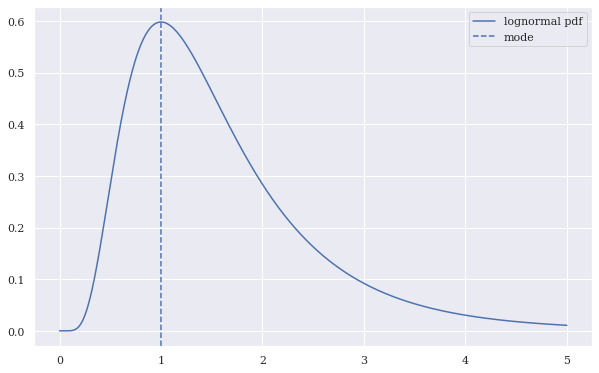

In [3]:
mode, sigma = 1, 1
lower, upper = 0, 5
mu_N, sigma_N = lognorm_params(mode, sigma)

x = np.linspace(lower, upper, 1000)
y = lognorm_pdf(x, mu_N, sigma_N)

sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Plot just the left-of-mode portion.

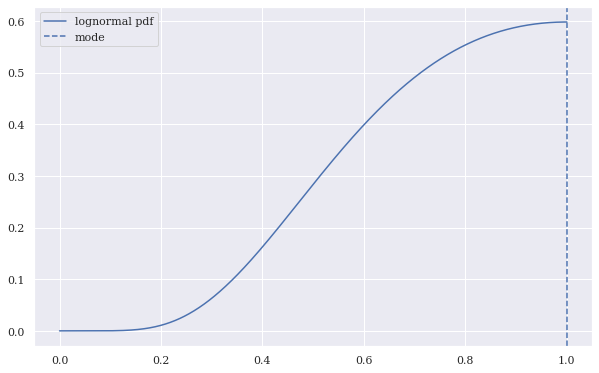

In [4]:
mode, sigma = 1, 1
mu_N, sigma_N = lognorm_params(mode, sigma)

x = np.linspace(lower, mode, 1000)
y = lognorm_pdf(x, mu_N, sigma_N)

sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Assign, for example, an upper bound of 5. Plot the left-of-mode portion of a lognormal pdf with $m = upper - mode$ and a reversed $x$ values. This is the right-of-mode portion of a new bounded lognormal pdf.

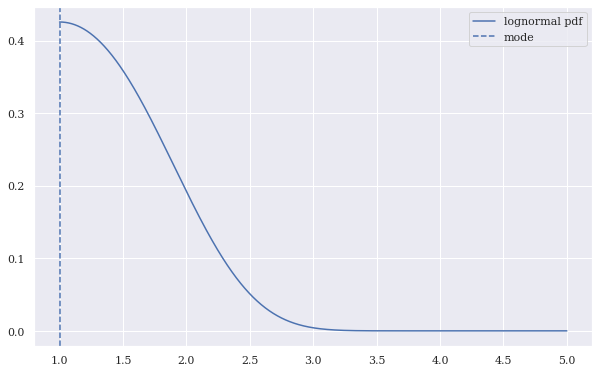

In [5]:
mode, sigma = 1, 1
lower, upper = 0, 5
mu_N, sigma_N = lognorm_params(upper - mode, sigma)

x = np.linspace(mode, upper, 1000)
y = lognorm_pdf(upper - x, mu_N, sigma_N)
sns.lineplot(x, y, label="lognormal pdf")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Concatenate the left-of-mode and right-of-mode curves above. Notice that they are discontinuous at the mode.

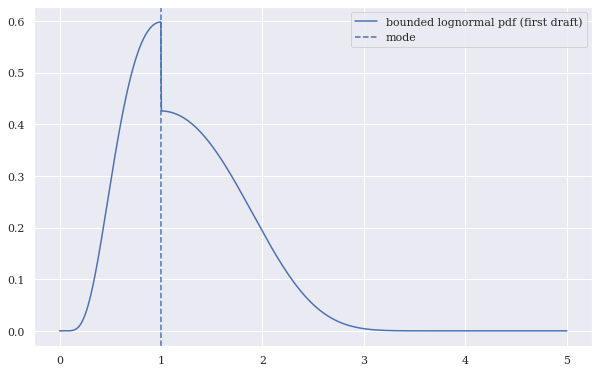

In [6]:
mu_N, sigma_N = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
y_left = lognorm_pdf(x_left, mu_N, sigma_N)

mu_N, sigma_N = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
y_right = lognorm_pdf(upper - x_right, mu_N, sigma_N)

x = np.concatenate([x_left, x_right])
y = np.concatenate([y_left, y_right])
sns.lineplot(x, y, label="bounded lognormal pdf (first draft)")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

Scale right side so that left and right sides are continuous at the mode.

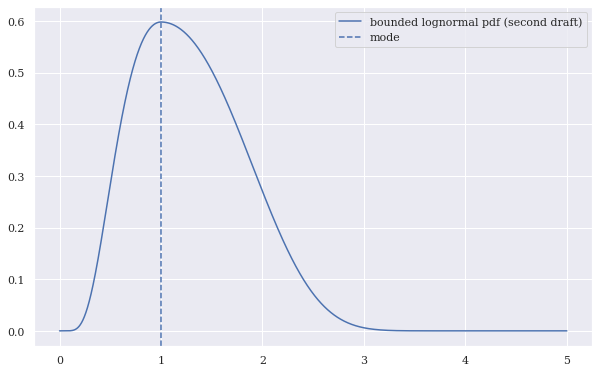

In [7]:
mu_N, sigma_N = lognorm_params(mode, sigma)
x_left = np.linspace(lower, mode, 1000)
x_left = np.append(x_left, [mode], axis=0)
y_left = lognorm_pdf(x_left, mu_N, sigma_N)

mu_N, sigma_N = lognorm_params(upper - mode, sigma)
x_right = np.linspace(mode, upper, 1000)
x_right = np.append(x_right, [mode], axis=0)
y_right = lognorm_pdf(upper - x_right, mu_N, sigma_N)

right_scale =  y_left[-1] / y_right[-1]

y_right = y_right * right_scale

x = np.concatenate([x_left[:-1], x_right[:-1]])
y = np.concatenate([y_left[:-1], y_right[:-1]])
sns.lineplot(x, y, label="bounded lognormal pdf (second draft)")
plt.axvline(mode, linestyle='dashed', label="mode")
plt.legend()
plt.show()

What remains in order to use this as a probability density function is to scale the entire curve, so the area under the curve = 1.

### Example Usage

#### Function Plots and Random Number Generation

Probability density functions (pdf) with various modes and sigmas, respectively.

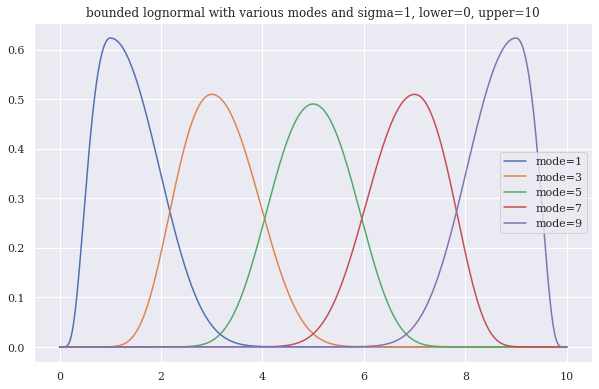

In [8]:
modes = [1, 3, 5, 7, 9]
sigma = 1
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)

for mode in modes:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='mode=' + str(mode))
plt.title('bounded lognormal with various modes and sigma=' + str(sigma) +
          ', lower=' + str(lower) +
          ', upper=' + str(upper))
plt.show()

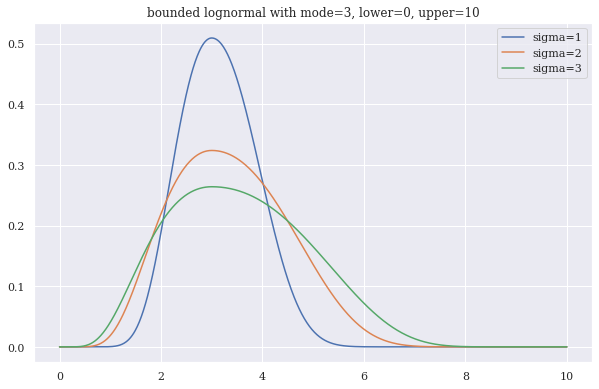

In [9]:
mode = 3
sigmas = [1, 2, 3]
lower, upper = 0, 10
x = np.linspace(lower, upper, 1000)

for sigma in sigmas:
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x, y, label='sigma=' + str(sigma))
plt.title('bounded lognormal with mode=' + str(mode) +
          ', lower=' + str(lower) +
          ', upper=' + str(upper))
plt.show()

Probability density function (pdf) with 95% confidence interval

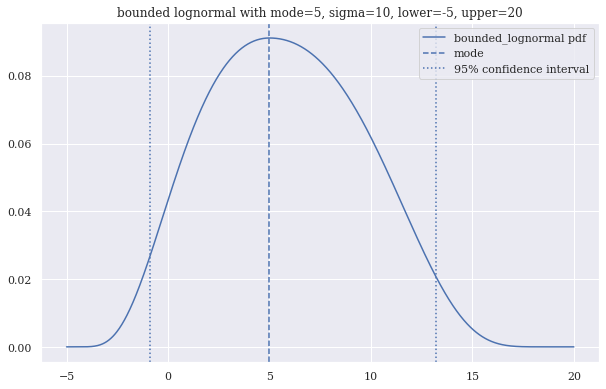

In [10]:
mode, sigma = 5, 10
lower, upper = -5, 20

x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y, label='bounded_lognormal pdf')
plt.axvline(mode, ymin=0, linestyle='dashed', label='mode')

interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
plt.axvline(interval[0], ymin=0, linestyle='dotted', 
            label='95% confidence interval')
plt.axvline(interval[1], ymin=0, linestyle='dotted')
title = ('bounded lognormal with mode=' + str(mode) +
          ', sigma=' + str(sigma) +
          ', lower=' + str(lower) +
          ', upper=' + str(upper))
plt.title(title)
plt.legend()
plt.show()

In [11]:
%timeit -r 3 bounded_lognorm.pdf(x, mode, sigma, lower, upper)

The slowest run took 4.59 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 400 µs per loop


Cumulative distribution function (cdf)

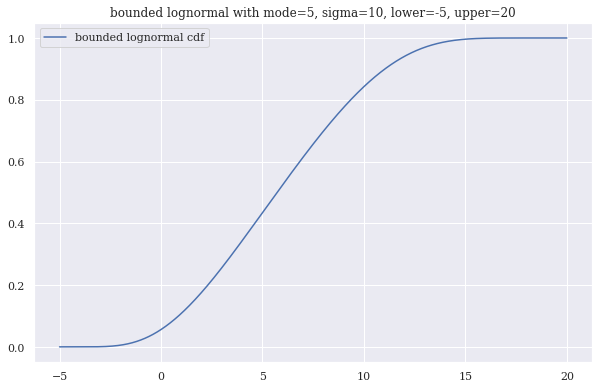

In [12]:
x = np.linspace(lower, upper, 1000)
y = bounded_lognorm.cdf(x, mode, sigma, lower, upper)
sns.lineplot(x, y, label='bounded lognormal cdf')
plt.title(title)
plt.show()

Percent point function (ppf), the inverse of the cdf.

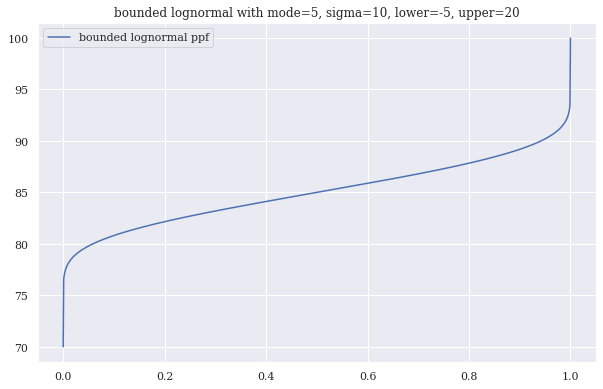

In [13]:
x = np.linspace(0, 1, 1000)
y = bounded_lognorm.ppf(x, mode=85, sigma=5, lower=70, upper=100)
sns.lineplot(x, y, label='bounded lognormal ppf')
plt.title(title)
plt.show()

In [14]:
%timeit bounded_lognorm.ppf(x, mode=85, sigma=5, lower=70, upper=100)

1000 loops, best of 3: 1.42 ms per loop


Print 100 random numbers from this distribution.

In [15]:
bounded_lognorm.rvs(mode=mode, sigma=sigma, lower=lower, upper=upper, size=100)

array([11.57491244,  1.28926718,  9.83893742,  7.02393278,  6.52063366,
        5.3104591 ,  9.31474017,  3.39440444,  8.94996654,  0.63733234,
       10.9678153 ,  6.86108525,  5.62223954,  1.20084379,  3.72606012,
        2.81242833, 10.33116648,  3.92336977,  2.6110025 ,  7.30201605,
        8.48744958,  6.73562474,  5.39861332,  7.42728733,  8.92064334,
        3.66916271,  6.14530993,  8.33039374, 10.87642461,  5.43948166,
        6.58758353,  5.38800198,  0.58737292,  2.46653031,  3.94917563,
        8.12253549,  4.46905813,  8.70775487,  3.28152298, 11.17644487,
        7.19460355,  4.02961517,  7.73343668,  3.67290827,  1.25627124,
        7.13942458,  9.38122846,  4.42143986,  5.67689595,  0.49976586,
        0.7078128 , 10.16469709,  6.05946908,  0.88870959,  4.81314091,
       10.10121735, 11.26882566,  4.55431897,  2.39725668,  7.09931683,
        8.41246746,  9.06049859,  1.07229913,  9.7427447 , 11.52972763,
       -1.23283728,  8.98462631, 10.12327071,  0.18973497,  6.40

Plot a histogram of 1000 random numbers from this distribution.

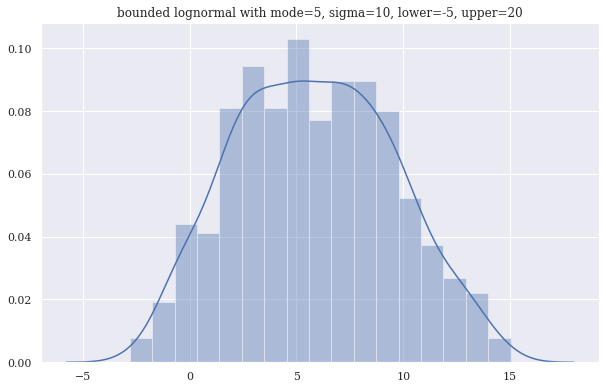

In [16]:
y = bounded_lognorm.rvs(mode=mode, sigma=sigma, lower=lower, upper=upper, 
                        size=1000)
sns.distplot(y)
plt.title(title)
plt.show()

#### Summary Statistics

Median

In [17]:
bounded_lognorm.median(mode, sigma, lower, upper)

array(5.72045175)

Mean

In [18]:
bounded_lognorm.mean(mode, sigma, lower, upper)

5.849409136297276

In [19]:
quad(bounded_lognorm.ppf, 0, 1, args=(mode, sigma, lower, upper))[0]

5.849409136297276

Standard deviation

In [20]:
bounded_lognorm.std(mode, sigma, lower, upper)

3.811695279149043

Note that this is *not* the same as $\sigma$, due to the proximity of the lower and upper domain boundaries. See the section below comparing the bounded lognormal and normal distributions for an illustration.

Central moments

In [21]:
mean, var, skew, kurt = bounded_lognorm.stats(mode, sigma, lower, upper, 
                                              moments='mvsk')
mean, var, skew, kurt 

(array(5.84940914), array(14.5290209), array(0.13655249), array(-0.6632001))

#### Curve Fitting

Create some noisy random numbers and fit them to a bounded_lognorm.pdf using non-linear least squares.

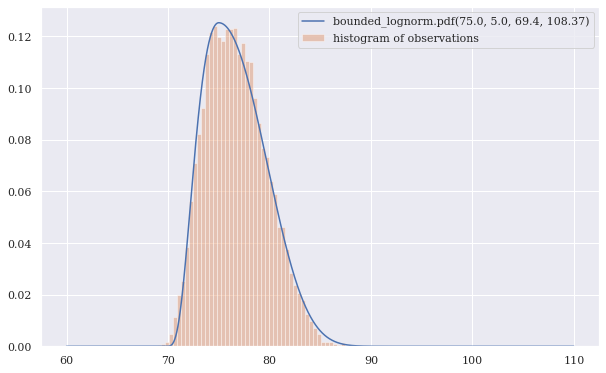

In [22]:
sample_size = 10000
ydata = bounded_lognorm.rvs(75, 5, 70, 100, size=sample_size)
ydata += 1 * np.random.normal(0, 1, size=sample_size) # add some noise

# Here, fmode=75 and fsigma=5 mean fix the params mode and sigma to 75 and 5,
# respectively, and estimate the other params.
shapes, popt, pcov = bounded_lognorm.fit(ydata, fmode=75, fsigma=5, MLE=False)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf' + str(shapes_rounded)) 

xdata = np.linspace(60, 110, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(ydata, kde=False, norm_hist=True, 
             label="histogram of observations")

plt.legend(loc='upper right')
plt.show()

Covariance matrix of estimated parameters, in this case `lower` and `upper`

In [23]:
pcov

array([[0.0111504 , 0.00854698],
       [0.00854698, 3.77104465]])

Standard deviation of estimated parameters, in this case `lower` and `upper`

In [24]:
np.sqrt(np.diag(pcov))

array([0.10559548, 1.94191778])

Fit the same random numbers to a bounded_lognorm.pdf using maximum likelihood estimation.

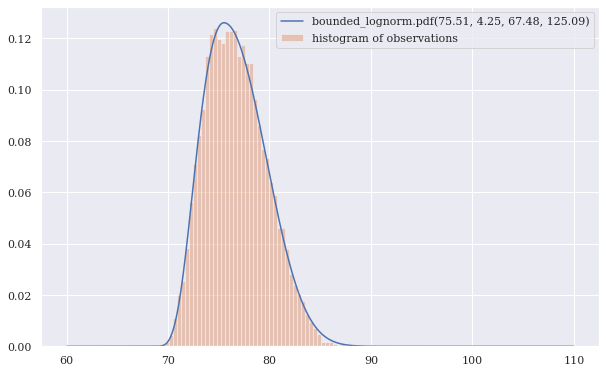

In [25]:
# Here, gmode=75 and gsigma=5 mean provide initial guesses of 75 and 5 to  
# mode and sigma, respectively. All parameters here are estimated.
shapes, popt, pcov = bounded_lognorm.fit(ydata, gmode=75, gsigma=5, MLE=True)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf' + str(shapes_rounded)) 

xdata = np.linspace(60, 110, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(ydata, kde=False, norm_hist=True, 
             label="histogram of observations")

plt.legend(loc='upper right')
plt.show()

Fit x and y data  to a pdf.

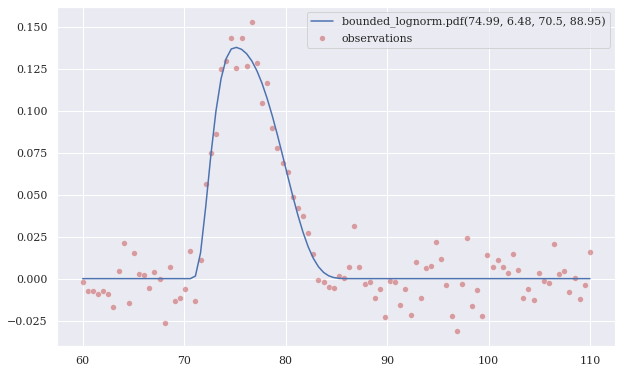

In [26]:
sample_size = 100
xdata = np.linspace(60, 110, sample_size)
ydata = bounded_lognorm.pdf(xdata, 75, 5, 70, 100)
ydata += 0.01 * np.random.normal(0, 1, size=sample_size) # add some noise

shapes, popt, pcov = bounded_lognorm.fit(ydata, xdata, gmode=75, gsigma=5)

shapes_rounded = tuple(shapes.round(2))
label = ('bounded_lognorm.pdf' + str(shapes_rounded)) 

sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.scatterplot(xdata, ydata, alpha=0.5, color='r', label='observations')

plt.legend()
plt.show()

### Compared to Other Distributions

#### The Normal Distribution

Let's first define a function that plots normal and symmetrical bounded lognormal pdfs for comparison. Include the 95% confidence interval for each. Take as a paramater _spread_ or distance from the mode to domain boundaries.

In [27]:
def compare_to_standard_N(spread):
    mode, sigma = 0, 1
    lower = mode - spread
    upper = mode + spread

    x = np.linspace(-4, 4, 1000)
    y = bounded_lognorm.pdf(x, mode, sigma, lower, upper)
    sns.lineplot(x,y, label='bounded lognormal pdf')

    interval = bounded_lognorm.interval(0.95, mode, sigma, lower, upper)
    plt.axvline(interval[0], ymin=0, linestyle='dashed', 
                label='bounded lognormal 95% conf. interval')
    plt.axvline(interval[1], ymin=0, linestyle='dashed')

    y = norm.pdf(x, loc=mode, scale=sigma)
    sns.lineplot(x,y, label='standard normal pdf')

    interval2 = norm.interval(0.95, loc=mode, scale=sigma)
    plt.axvline(interval2[0], ymin=0, linestyle='dashed', c='red', alpha=0.5,
                label='standard normal 95% conf interval')
    plt.axvline(interval2[1], ymin=0, linestyle='dashed', c='red', alpha=0.5)

    plt.legend()
    plt.show()

As the upper and lower bounds move away from the mode, the bounded lognormal pdf appears to better approximate the normal pdf.

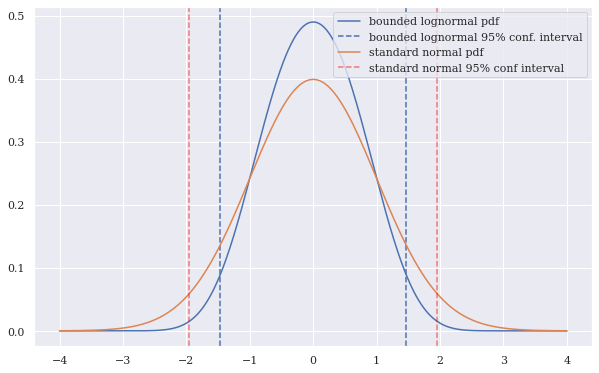

In [28]:
compare_to_standard_N(5)

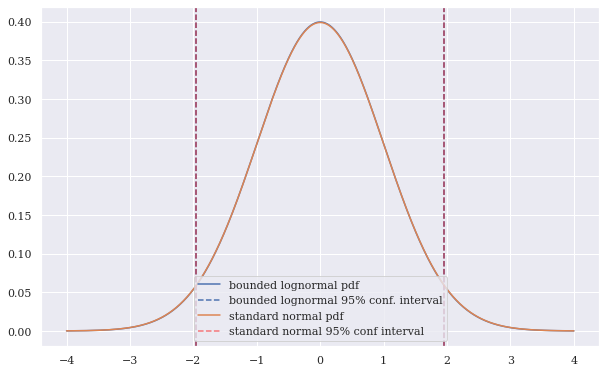

In [29]:
compare_to_standard_N(500)

However, as the spread continues to widen, the confidence intervals diverge. Why?

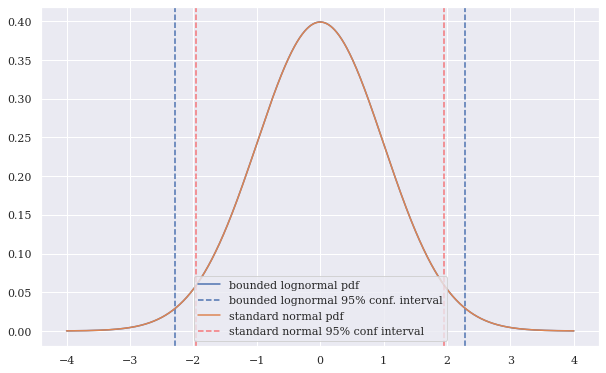

In [30]:
compare_to_standard_N(5000)

This is probably a bug having to do with the way population variance (and standard deviation) is calculated. A population standard deviation > 1 is consistent with the wider than expected confidence interval above. 

In [31]:
spread = 5000
mode, sigma = 0, 1
lower = mode - spread
upper = mode + spread
wide_BL = bounded_lognorm(mode, sigma, lower, upper)
wide_BL.std()

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1695: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return integrate.quad(self._mom_integ1, 0, 1, args=(m,)+args)[0]


1.1544889781459295

However, the sample standard deviation (of a large sample) is not significantly different than 1. Moreover, we cannot reject the null hypothesis that the sample comes from a normal distribution.

In [32]:
wide_BL_sample = wide_BL.rvs(size=100000)
wide_BL_sample.std()

1.001191123396267

In [33]:
normaltest(wide_BL_sample, axis=0, nan_policy='propagate')

NormaltestResult(statistic=2.9193553750423225, pvalue=0.23231113944341084)

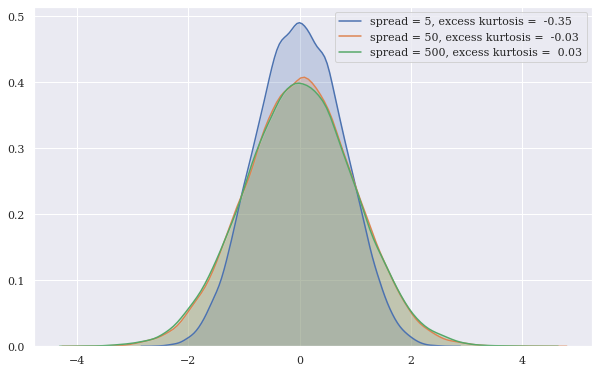

In [34]:
mode, sigma = 0, 1

spreads = [5, 50, 500]
for spread in spreads:

    lower = mode - spread
    upper = mode + spread

    y = bounded_lognorm.rvs(mode, sigma, lower, upper, size=max(spreads)*100)
    k = kurtosis(y, fisher=True)
    label = 'spread = ' + str(spread)
    label += ', excess kurtosis =  ' + str(round(k,2))
    sns.kdeplot(y, label=label, shade=True)
plt.legend()
plt.show()

#### The Truncated Normal Distribution

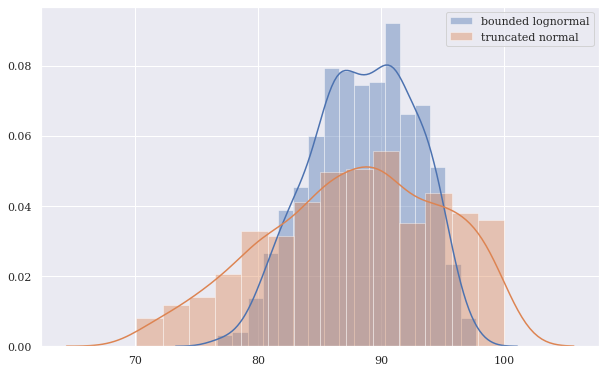

In [35]:
mode, sigma = 90, 10
lower, upper = 70, 100

sns.distplot(bounded_lognorm.rvs(mode=mode, sigma=sigma, 
                                 lower=lower, upper=upper, size=1000),
             label='bounded lognormal')
sns.distplot(truncnorm.rvs((lower - mode) / sigma,  
                           (upper - mode) / sigma,
                           mode, sigma, size=1000),
             label='truncated normal')
plt.legend()
plt.show()

### Applications

#### What are the fastest possible 100m sprint times?

Let's first load data from the 2004-2016 Olympics. See [here](https://deepblue.lib.umich.edu/data/concern/data_sets/cr56n184r?locale=en) for details on this dataset.

In [36]:
url = 'https://deepblue.lib.umich.edu/data/downloads/qn59q4716?locale=en'
sprint_data = pd.read_csv(url, encoding="ISO-8859-1")
sprint_data.head()

,POS,BIB,ATHLETE,COUNTRY,MARK,RxnTime,Race,Round,Gender,Year
0,1.0,NaN,Usain BOLT,JAMJAM,10.20 Q,0.186,100 m,Heats,M,2008
1,2.0,NaN,Daniel BAILEY,ANTANT,10.24 Q,0.198,100 m,Heats,M,2008
2,3.0,NaN,Vicente DE LIMA,BRABRA,10.26 Q,0.168,100 m,Heats,M,2008
3,4.0,NaN,Henry VIZCAÍNO,CUBCUB,10.28 q,0.157,100 m,Heats,M,2008
4,5.0,NaN,Fabio CERUTTI,ITAITA,10.49,0.136,100 m,Heats,M,2008


Isolate the 100m sprint times, clean up the `MARK` field (time in seconds), and convert to average speed (meters per second). 

In [37]:
sprint_data = sprint_data[sprint_data.Race == "100 m"]
sprint_data['speed'] = sprint_data.MARK.str.split(expand=True)[0]
sprint_data['speed'] = pd.to_numeric(sprint_data['speed'],'coerce')
sprint_data = sprint_data[sprint_data['speed']>0]
sprint_data['speed'] = 100 / sprint_data['speed']
sprint_data.head()

,POS,BIB,ATHLETE,COUNTRY,MARK,RxnTime,Race,Round,Gender,Year,speed
0,1.0,NaN,Usain BOLT,JAMJAM,10.20 Q,0.186,100 m,Heats,M,2008,9.803922
1,2.0,NaN,Daniel BAILEY,ANTANT,10.24 Q,0.198,100 m,Heats,M,2008,9.765625
2,3.0,NaN,Vicente DE LIMA,BRABRA,10.26 Q,0.168,100 m,Heats,M,2008,9.746589
3,4.0,NaN,Henry VIZCAÍNO,CUBCUB,10.28 q,0.157,100 m,Heats,M,2008,9.727626
4,5.0,NaN,Fabio CERUTTI,ITAITA,10.49,0.136,100 m,Heats,M,2008,9.532888


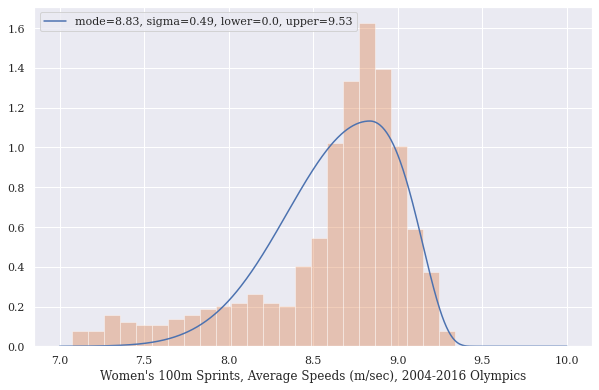

In [38]:
ydata = sprint_data[sprint_data.Gender == 'F']['speed']
sample_size = len(ydata)
shapes, popt, pcov = bounded_lognorm.fit(ydata, 
                                         fmode=ydata.mode()[0],
                                         fsigma=ydata.std(),
                                         flower=0)
shapes_rounded = shapes.round(2)
label = (    'mode=' + str(shapes_rounded[0]) +
          ', sigma=' + str(shapes_rounded[1]) +
          ', lower=' + str(shapes_rounded[2]) +
          ', upper=' + str(shapes_rounded[3]))
xdata = np.linspace(7, 10, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(ydata[ydata>7], kde=False, norm_hist=True)
plt.xlabel("Women's 100m Sprints, Average Speeds (m/sec), 2004-2016 Olympics")
plt.legend()
plt.show()

In [39]:
bpt = 100/popt[-1] 
bpt.round(2)

10.49

In [40]:
stdev = np.sqrt(np.diag(pcov))[0]
conf_interval = np.array([bpt - 2 * stdev, bpt + 2 * stdev])
conf_interval.round(2)

array([10.3 , 10.69])

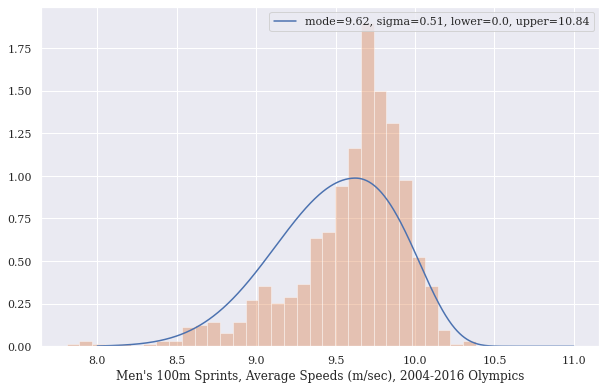

In [41]:
ydata = sprint_data[sprint_data.Gender == 'M']['speed']
sample_size = len(ydata)
shapes, popt, pcov = bounded_lognorm.fit(ydata, 
                                         fmode=ydata.mode()[0],
                                         fsigma=ydata.std(),
                                         flower=0)
shapes_rounded = shapes.round(2)
label = (    'mode=' + str(shapes_rounded[0]) +
          ', sigma=' + str(shapes_rounded[1]) +
          ', lower=' + str(shapes_rounded[2]) +
          ', upper=' + str(shapes_rounded[3]))
xdata = np.linspace(8, 11, sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(ydata[ydata>7], kde=False, norm_hist=True)
plt.xlabel("Men's 100m Sprints, Average Speeds (m/sec), 2004-2016 Olympics")
plt.legend()
plt.show()

In [42]:
bpt = 100/popt[0] 
bpt.round(2)

9.22

In [43]:
stdev = np.sqrt(np.diag(pcov))[0]
conf_interval = np.array([bpt - 2 * stdev, bpt + 2 * stdev])
conf_interval.round(2)

array([8.99, 9.45])

#### Maximum Adult Male Height

https://phc.amedd.army.mil/topics/workplacehealth/ergo/Pages/Anthropometric-Database.aspx
http://tools.openlab.psu.edu/publicData/ANSURII-MFR.pdf
https://www.quora.com/What-is-the-theoretical-maximum-height-limit-for-a-human

In [44]:
url = 'https://phc.amedd.army.mil/PHC%20Resource%20Library/ANSURIIMALEPublic.csv'
ANSUR2M = pd.read_csv(url, encoding="ISO-8859-1")
# ANSUR2M.columns.values  # to see sorted list of column names

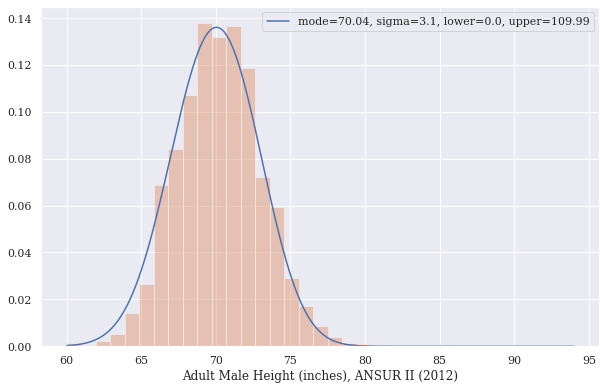

In [45]:
ydata = ANSUR2M[ANSUR2M.Gender == 'Male']['Heightin']
sample_size = len(ydata)
shapes, popt, pcov = bounded_lognorm.fit(ydata, 
                                         #fmode=ydata.mode()[0],
                                         fmode=ydata.mean(),
                                         #fsigma=ydata.std(),
                                         flower=0)
shapes_rounded = shapes.round(2)
label = (    'mode=' + str(shapes_rounded[0]) +
          ', sigma=' + str(shapes_rounded[1]) +
          ', lower=' + str(shapes_rounded[2]) +
          ', upper=' + str(shapes_rounded[3]))
xdata = np.linspace(ydata.min(), ydata.max(), sample_size)
sns.lineplot(xdata, bounded_lognorm.pdf(xdata, *shapes), label=label)
sns.distplot(ydata, kde=False, norm_hist=True, bins=35)
plt.xlabel("Adult Male Height (inches), ANSUR II (2012)")
plt.legend()
plt.show()

In [46]:
tallest = popt[1] 
tallest.round()

110.0

In [47]:
int(tallest//12), int(tallest.round()%12)

(9, 2)

In [48]:
stdev = np.sqrt(np.diag(pcov))[0]
conf_interval = np.array([tallest - 2 * stdev, tallest + 2 * stdev])
conf_interval.round()

array([108., 112.])